In [1]:
%%capture capt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import pickle

### Dictionnaires de GridSearch pour les meilleurs paramètres de chaque fonction

In [2]:
with open('../data/grid_search/gridSearch.pickle', 'rb') as handle:
    grid_search = pickle.load(handle)
print(len(grid_search))

4199


In [3]:
with open('../data/grid_search/gridSearch_norm.pickle', 'rb') as handle:
    grid_search_norm = pickle.load(handle)
print(len(grid_search_norm))

4226


In [4]:
with open('../data/grid_search/gridSearch_scaled.pickle', 'rb') as handle:
    grid_search_scaled = pickle.load(handle)
print(len(grid_search_scaled))

4646


In [5]:
with open('../data/grid_search/gridSearch_filter.pickle', 'rb') as handle:
    grid_search_filter = pickle.load(handle)
print(len(grid_search_filter))

812


In [6]:
def get_nb_clusters_from_key(key):
    return int(key.split(',')[0].split(':')[-1])

def get_meilleurs_params(dic, max_clusters=None):
    max_score = -float('inf')
    max_key = ''
    if not max_clusters:
        max_clusters = float('inf')
        
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) <= max_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [7]:
best_params_norm = get_meilleurs_params(grid_search_norm)
print(f"Meilleurs params normalise --> {best_params_norm}")

Meilleurs params normalise --> (0.058388449763529505, 'n_clusters:33, weights:50 5 1')


In [8]:
best_params = get_meilleurs_params(grid_search)
print(f"Meilleurs params non normalise --> {best_params}")

Meilleurs params non normalise --> (0.05881224330601615, 'n_clusters:5, weights:50 50 5')


In [9]:
best_params_scaled = get_meilleurs_params(grid_search_scaled)
print(f"Meilleurs params scaled --> {best_params_scaled}")

Meilleurs params scaled --> (0.9684855479335592, 'n_clusters:39, weights:45 10 1')


In [10]:
best_params_filter = get_meilleurs_params(grid_search_filter)
print(f"Meilleurs params scaled --> {best_params_filter}")

Meilleurs params scaled --> (1.856686331979772e-05, 'n_clusters:5, weights:20 10 5')


In [11]:
def score_fct_clusters(dic, title):
    range_max_clusters = range(5, 42)
    best_params_scaled = [get_meilleurs_params(dic, max_clusters=max_clusters)[0] for max_clusters in range_max_clusters]
    plt.plot(range_max_clusters, best_params_scaled)
    plt.title(f"Max score clusters en fonction du nombre max de clusters autorisés\n{title}")
    plt.xlabel("Nb clusters max autorisé")
    plt.show()

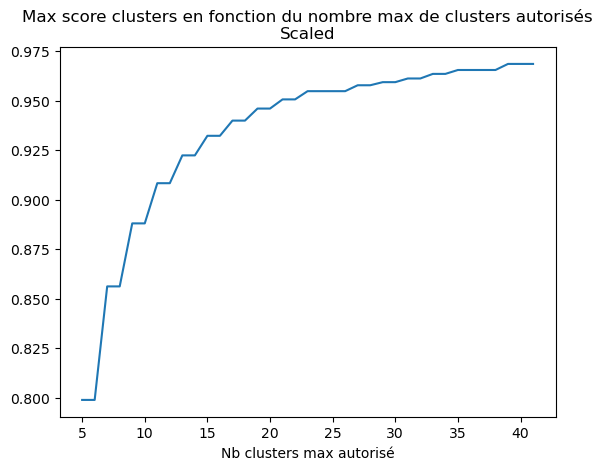

In [12]:
score_fct_clusters(grid_search_scaled, 'Scaled')

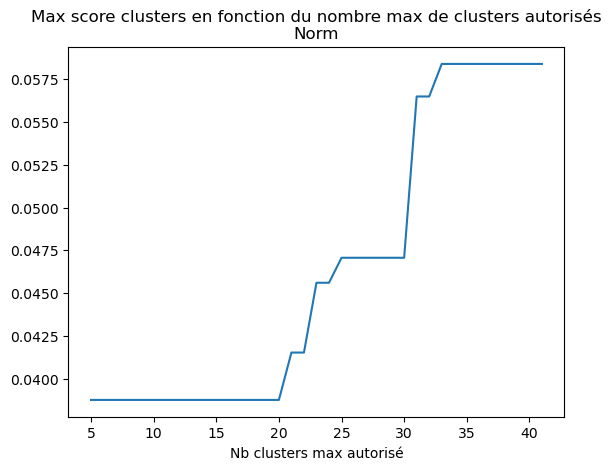

In [13]:
score_fct_clusters(grid_search_norm, 'Norm')

### Meilleur par nombre de clusters

In [14]:
def get_best_params_fixed_n_clusters(dic, n_clusters):
    max_score = -float('inf')
    max_key = ''
    for key in dic.keys():
        if dic[key] >= max_score and get_nb_clusters_from_key(key) == n_clusters:
            max_score, max_key = dic[key], key
    return max_score, max_key

In [15]:
def score_by_n_clusters(dic, title):
    range_clusters = range(5, 32, 2)
    best_params = [get_best_params_fixed_n_clusters(dic, n_clusters)[0] for n_clusters in range_clusters]
    plt.plot(range_clusters, best_params)
    plt.title(f"Max score clusters en fonction du nombre de clusters\n{title}")
    plt.xlabel("Nb clusters")
    plt.show()

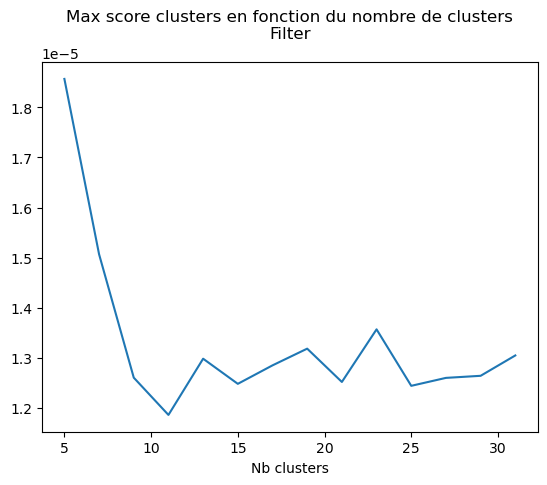

In [16]:
score_by_n_clusters(grid_search_filter, 'Filter')

### Clustering pour chacun des meilleurs params

In [17]:
%run Calculate_clusters.ipynb

Installation/Importation des librairies necessaires.
CPU cores available -> 72


In [18]:
def get_weights_from_params(params):
    key = params[1].split(',')[-1].split(':')[-1].split(' ')
    weights_params = [int(weight) for weight in key]
    return weights_params

In [19]:
import warnings
warnings.filterwarnings("ignore")

#### Custom scaled

In [ ]:
max_clusters = 21
best_params_scaled_max_clusters = get_meilleurs_params(grid_search_scaled, max_clusters=max_clusters)
print(best_params_scaled_max_clusters)

In [ ]:
kmedoids_scaled_max_clusters, base_scaled_max_clusters = base_finale(X_patient, 'custom', scaled=True, 
                                                 weights_metric=get_weights_from_params(best_params_scaled_max_clusters), 
                                                 n_clusters = get_nb_clusters_from_key(best_params_scaled_max_clusters[-1]))

In [ ]:
base_scaled_max_clusters.to_csv('../data/grid_search/scaled.csv', index=False)
medoid_indices = kmedoids_scaled_max_clusters.medoid_indices_
with open('../data/grid_search/scaled_medoids.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom norm

In [ ]:
max_clusters = 25

In [ ]:
best_params_norm = get_meilleurs_params(grid_search_norm, 25)
print(best_params_norm)

In [ ]:
kmedoids_norm, base_norm = base_finale(X_patient, 'custom_norm', scaled=False, 
                                       weights_metric=get_weights_from_params(best_params_norm), 
                                       n_clusters = get_nb_clusters_from_key(best_params_norm[-1]))

In [ ]:
base_norm.to_csv('../data/grid_search/norm_25.csv', index=False)
medoid_indices = kmedoids_norm.medoid_indices_
with open('../data/grid_search/norm_medoids_25.npy', 'wb') as f:
    np.save(f, medoid_indices)

#### Custom

In [ ]:
best_params = get_meilleurs_params(grid_search)
print(best_params)

In [ ]:
kmedoids_std, base_std = base_finale(X_patient, 'custom', scaled=False, 
                                     weights_metric=get_weights_from_params(best_params), 
                                     n_clusters = get_nb_clusters_from_key(best_params[-1]))

### Filter

In [20]:
best_params_filter = get_best_params_fixed_n_clusters(grid_search_filter, 5)
print(best_params_filter)

(1.856686331979772e-05, 'n_clusters:5, weights:20 10 5')


In [21]:
kmedoids_filter, base_filter = base_finale(X_patient, 'filter_dist', scaled=True, 
                                     weights_metric=[20,10,5], 
                                     n_clusters = 9)

Calcul des distances, weights=[20, 10, 5]
Distances calculees en 551s, calcul des clusters -> n_clusters=9


In [23]:
for i in range(1, 9+1):
    print(base_filter[f'cluster{i}'].sum())

2997
57
1064
3137
5
160
2133
23
475


In [24]:
base_filter.to_csv('../data/grid_search/filter_20_10_5__9.csv', index=False)
medoid_indices = kmedoids_filter.medoid_indices_
with open('../data/grid_search/medoids_filter_20_10_5__9.npy', 'wb') as f:
    np.save(f, medoid_indices)